In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.plotting import (
    scatterplotmatrix,
    heatmap)

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures)
from sklearn.linear_model import (
    LinearRegression,
    RANSACRegressor,
    Ridge,
    Lasso,
    ElasticNet)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [12]:
columns=['Overall Qual','Overall Cond','Gr Liv Area',
         'Central Air','Total Bsmt SF','SalePrice']

df=pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',sep='\t',usecols=columns)
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [13]:
df.shape

(2930, 6)

### EDA

In [14]:
df['Central Air']=df['Central Air'].map({'Y':1,'N':0})

In [15]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [16]:
df=df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

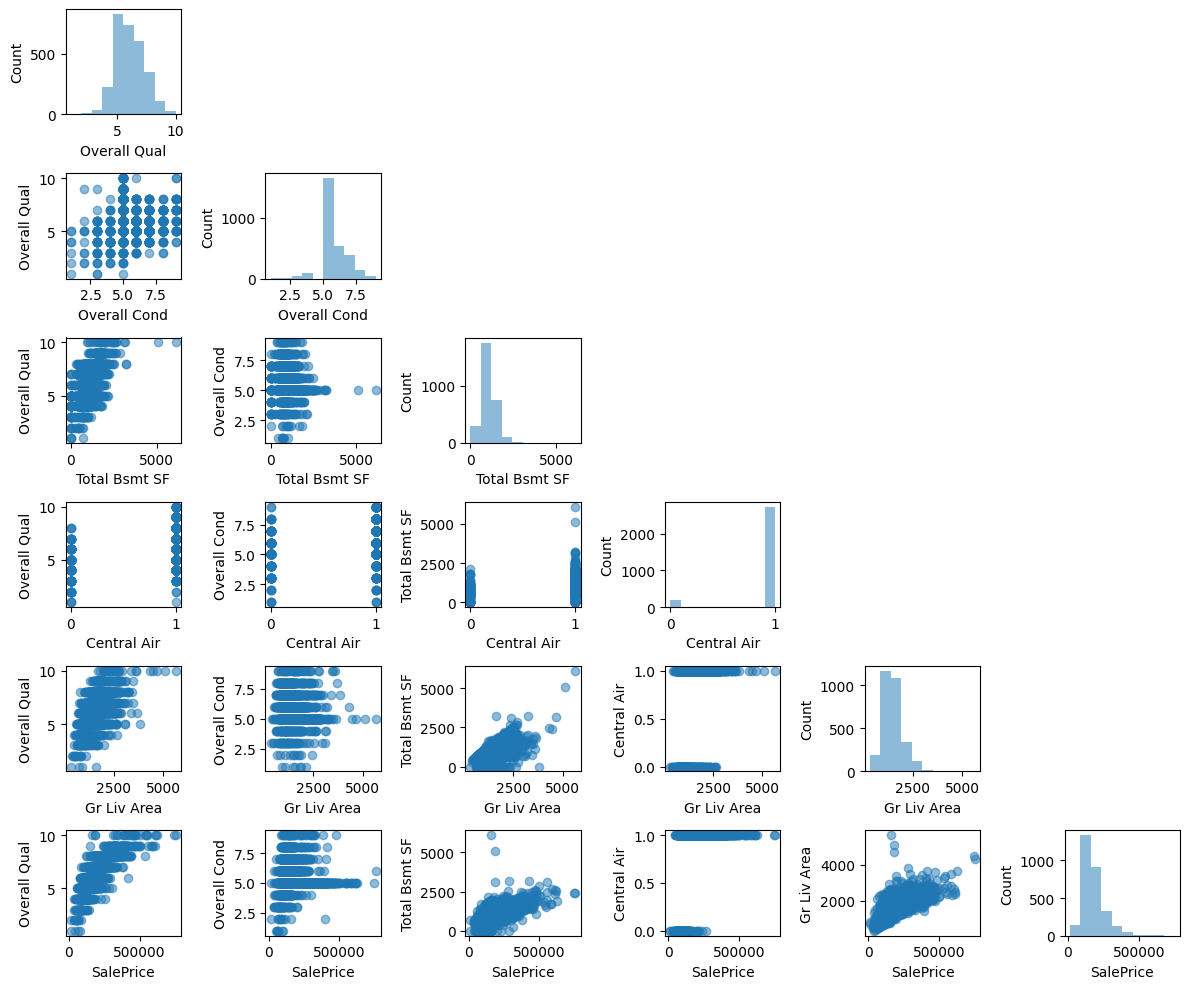

In [17]:
scatterplotmatrix(df.values,figsize=(12,10),
                  names=df.columns,alpha=0.5)
plt.tight_layout()
plt.show()

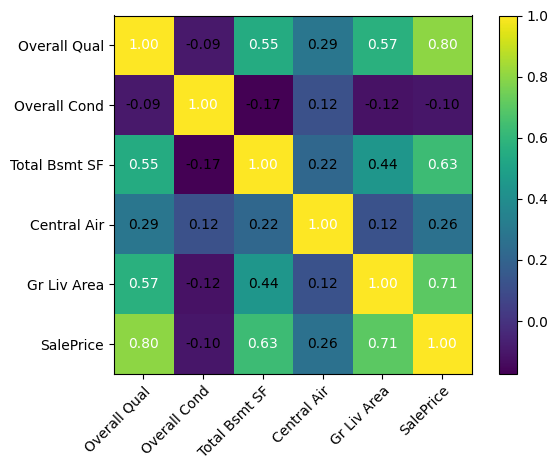

In [18]:
cm=np.corrcoef(df.values.T)
hm=heatmap(cm,row_names=df.columns,column_names=df.columns)
plt.tight_layout()
plt.show()

In [23]:
class LinearRegressionGD:
    def __init__(self,eta=0.01,n_iter=50,random_state=1):
        self.eta=eta #learning rate
        self.n_iter=n_iter
        self.random_state=random_state

    def fit(self,X,y):
        rgen=np.random.RandomState(self.random_state)
        self.w_=rgen.normal(loc=0.0,scale=0.01,size=X.shape[1]) #loc->mean,scale->std
        self.b_=np.array([0.])
        self.losses_=[]

        for i in range(self.n_iter):
            output=self.net_input(X)
            errors=(y-output)
            self.w_+=self.eta*2.0*X.T.dot(errors)/X.shape[0]
            self.b_+=self.eta*2.0*errors.mean()
            loss=(errors**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self,X):
        return np.dot(X,self.w_)+self.b_
    
    def predict(self,X):
        return self.net_input(X)



In [24]:
X=df[['Gr Liv Area']].values
y=df['SalePrice'].values
sc_x=StandardScaler()
sc_y=StandardScaler()
X_std=sc_x.fit_transform(X)
y_std=sc_y.fit_transform(y[:,np.newaxis]).flatten()
lr=LinearRegressionGD(eta=0.1)
lr.fit(X_std,y_std)

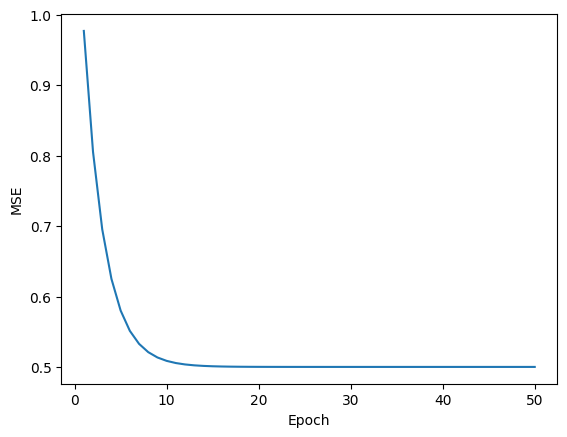

In [25]:
plt.plot(range(1,lr.n_iter+1),lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()


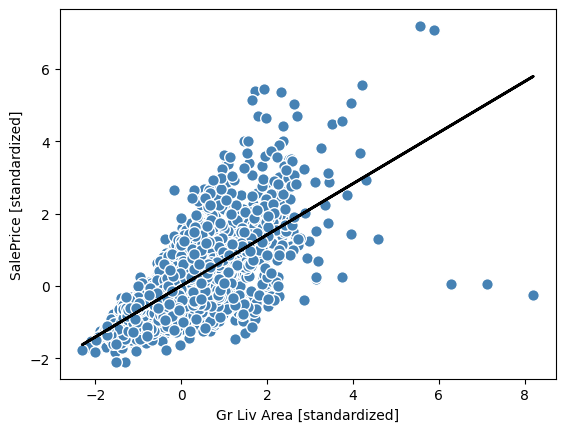

In [26]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='steelblue',edgecolor='white',s=70)
    plt.plot(X,model.predict(X),color='black',lw=2)

lin_regplot(X_std,y_std,lr)
plt.xlabel('Gr Liv Area [standardized]')
plt.ylabel('SalePrice [standardized]')
plt.show()    

In [27]:
feature_std=sc_x.fit_transform([[2500]])
target_std=lr.predict(feature_std)
target_reverted=sc_y.inverse_transform(target_std.reshape(-1,1))
print(f'Sales Proce: ${target_reverted.flatten()[0]:.2f}')

Sales Proce: $180830.81


In [28]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


In [19]:
slr=LinearRegression()
slr.fit(X,y)
y_pred=slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


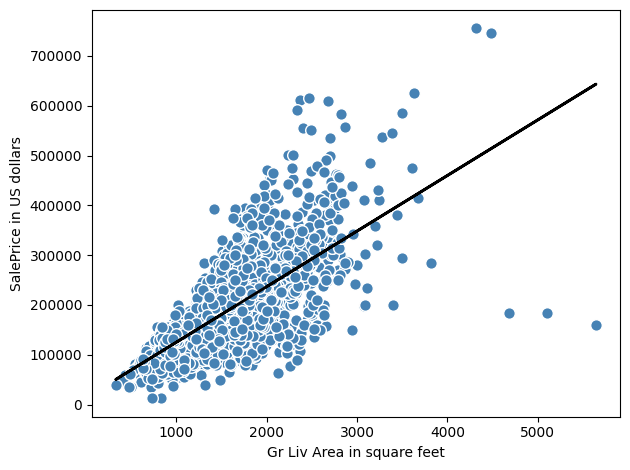

In [20]:
lin_regplot(X,y,slr)
plt.xlabel('Gr Liv Area in square feet')
plt.ylabel('SalePrice in US dollars')
plt.tight_layout()
plt.show()

### Scikit LR

In [29]:
from sklearn.linear_model import LinearRegression
slr=LinearRegression()
slr.fit(X,y)
y_pred=slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


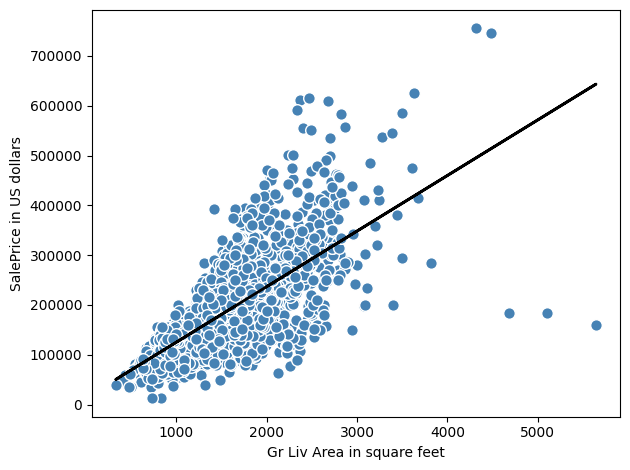

In [30]:
lin_regplot(X,y,slr)
plt.xlabel('Gr Liv Area in square feet')
plt.ylabel('SalePrice in US dollars')
plt.tight_layout()
plt.show()

Another way of LR 
$w$=$(X^TX)^{-1}X^Ty$

In [52]:
#adding a column vector of "ones"
xb=np.hstack((np.ones((X.shape[0],1)),X))
w=np.zeros(xb.shape[1])
z=np.linalg.inv(np.dot(xb.T,xb))
w=np.dot(z,np.dot(xb.T,y))
print(f'Slope: {w[1]:.3f}')
print(f'Intercept: {w[0]:.3f}')

Slope: 111.666
Intercept: 13342.979


### RANSAC

In [57]:
ransac=RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=50,
    residual_threshold=65000,
    random_state=123)
ransac.fit(X,y)

RANSACRegressor(estimator=LinearRegression(), min_samples=50, random_state=123,
                residual_threshold=65000)

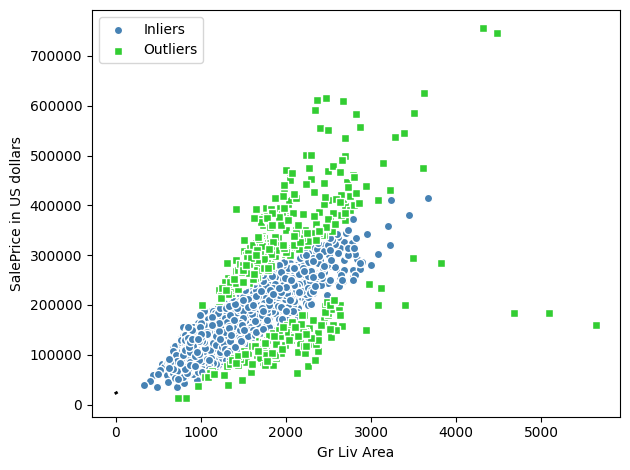

In [58]:
inlier_mask=ransac.inlier_mask_
outlier_mask=np.logical_not(inlier_mask)
line_X=np.arange(3,10,1)
line_y_ransac=ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],
            c='steelblue',edgecolor='white',
            marker='o',label='Inliers')
plt.scatter(X[outlier_mask],y[outlier_mask],
            c='limegreen',edgecolor='white',
            marker='s',label='Outliers')
plt.plot(line_X,line_y_ransac,color='black',lw=2)
plt.xlabel('Gr Liv Area')
plt.ylabel('SalePrice in US dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [55]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 99.391
Intercept: 25244.350


In [56]:
def mean_absolute_deviation(data):
    return np.mean(np.abs(data-np.mean(data)))
mean_absolute_deviation(y)

58269.561754979375

### Evaluation

In [60]:
target='SalePrice'
features=df.columns[df.columns!=target]
X=df[features].values
y=df[target].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
slr=LinearRegression()
slr.fit(X_train,y_train)
y_train_pred=slr.predict(X_train)
y_test_pred=slr.predict(X_test)

#### Residual plots

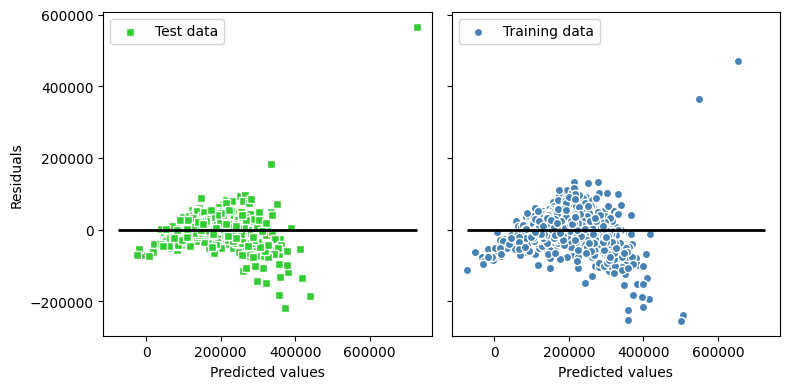

In [61]:
x_max=np.max([y_train_pred.max(),y_test_pred.max()])
x_min=np.min([y_train_pred.min(),y_test_pred.min()])

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4),sharey=True)

ax1.scatter(y_test_pred,y_test_pred-y_test,
            c='limegreen',marker='s',
            edgecolor='white',
            label='Test data')

ax2.scatter(y_train_pred,y_train_pred-y_train,
            c='steelblue',marker='o',
            edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1,ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0,xmin=x_min-100,xmax=x_max+100,color='black',lw=2)

plt.tight_layout()
plt.show()

In [63]:
mse_train=mean_squared_error(y_train,y_train_pred)
mse_test=mean_squared_error(y_test,y_test_pred)
print(f'MSE train: {mse_train:.3f}')
print(f'MSE test: {mse_test:.3f}')

MSE train: 1497216245.853
MSE test: 1516565820.999


In [66]:
mae_train=mean_absolute_error(y_train,y_train_pred)
mae_test=mean_absolute_error(y_test,y_test_pred)
print(f'MAE train: {mae_train:.3f}')
print(f'MAE test: {mae_test:.3f}')

MAE train: 25983.027
MAE test: 24921.289


In [68]:
train_r2=r2_score(y_train,y_train_pred)
test_r2=r2_score(y_test,y_test_pred)
print(f'R^2 train: {train_r2:.3f}')
print(f'R^2 test: {test_r2:.3f}')

R^2 train: 0.769
R^2 test: 0.752


#### Regularization

In [70]:
ridge=Ridge(alpha=1.0)

In [72]:
lasso=Lasso(alpha=1.0)

In [73]:
elanet=ElasticNet(alpha=1.0,l1_ratio=0.5)

#### Non linearity

In [75]:
X=np.array([258.0,270.0,294.0,320.0,342.0,368.0,396.0,446.0,480.0,586.0])[:,np.newaxis]
y=np.array([236.4,234.4,252.8,298.6,314.2,342.2,360.8,368.0,391.2,390.8])
lr=LinearRegression()
pr=LinearRegression()
quadratic=PolynomialFeatures(degree=2)
X_quad=quadratic.fit_transform(X)

In [76]:
lr.fit(X,y)
X_fit=np.arange(250,600,10)[:,np.newaxis]
y_lin_fit=lr.predict(X_fit)

In [77]:
pr.fit(X_quad,y)
y_quad_fit=pr.predict(quadratic.fit_transform(X_fit))

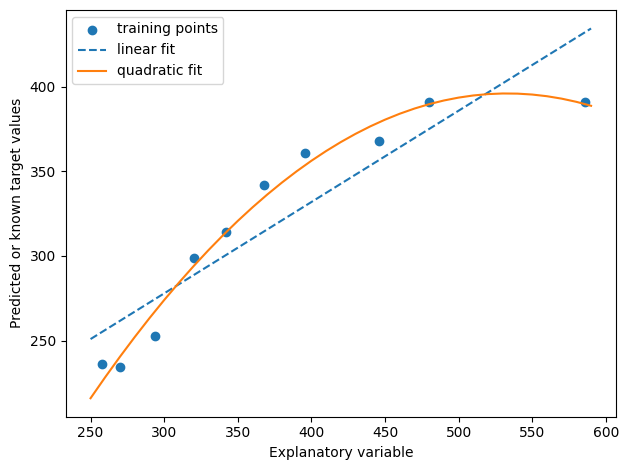

In [78]:
plt.scatter(X,y,label='training points')
plt.plot(X_fit,y_lin_fit,label='linear fit',linestyle='--')
plt.plot(X_fit,y_quad_fit,label='quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [79]:
y_lin_pred=lr.predict(X)
y_quad_pred=pr.predict(X_quad)
mse_lin=mean_squared_error(y,y_lin_pred)
mse_quad=mean_squared_error(y,y_quad_pred)
print(f'MSE linear: {mse_lin:.3f}, quadratic: {mse_quad:.3f}')

MSE linear: 569.780, quadratic: 61.330


In [80]:
r2_lin=r2_score(y,y_lin_pred)
r2_quad=r2_score(y,y_quad_pred)
print(f'R^2 linear: {r2_lin:.3f}, quadratic: {r2_quad:.3f}')

R^2 linear: 0.832, quadratic: 0.982


### Modelling Non linear relationships

In [81]:
X=df[['Gr Liv Area']].values
y=df['SalePrice'].values
X=X[(df['Gr Liv Area']<4000)]
y=y[(df['Gr Liv Area']<4000)]

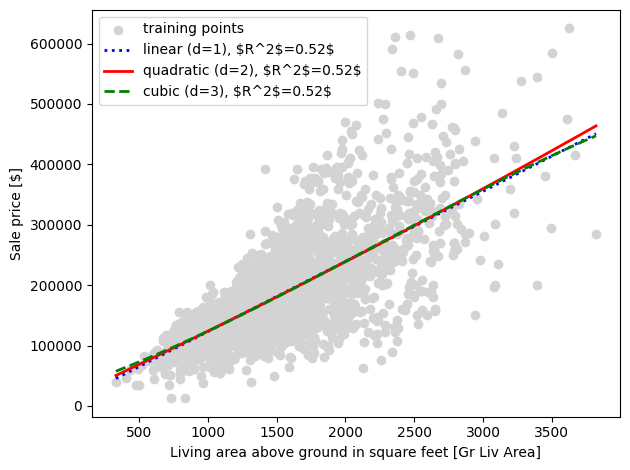

In [82]:
regr=LinearRegression()

quadratic=PolynomialFeatures(degree=2)
cubic=PolynomialFeatures(degree=3)
X_quad=quadratic.fit_transform(X)
X_cubic=cubic.fit_transform(X)

X_fit=np.arange(X.min()-1,X.max()+2,1)[:,np.newaxis]
regr.fit(X,y)
y_lin_fit=regr.predict(X_fit)
linear_r2=r2_score(y,regr.predict(X))
regr.fit(X_quad,y)
y_quad_fit=regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2=r2_score(y,regr.predict(X_quad))
regr.fit(X_cubic,y)
y_cubic_fit=regr.predict(cubic.fit_transform(X_fit))
cubic_r2=r2_score(y,regr.predict(X_cubic))

plt.scatter(X,y,label='training points',color='lightgray')
plt.plot(X_fit,y_lin_fit,label=f'linear (d=1), $R^2$={linear_r2:.2f}$',color='blue',lw=2,linestyle=':')
plt.plot(X_fit,y_quad_fit,label=f'quadratic (d=2), $R^2$={quadratic_r2:.2f}$',color='red',lw=2,linestyle='-')
plt.plot(X_fit,y_cubic_fit,label=f'cubic (d=3), $R^2$={cubic_r2:.2f}$',color='green',lw=2,linestyle='--')
plt.xlabel('Living area above ground in square feet [Gr Liv Area]')
plt.ylabel('Sale price [$]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

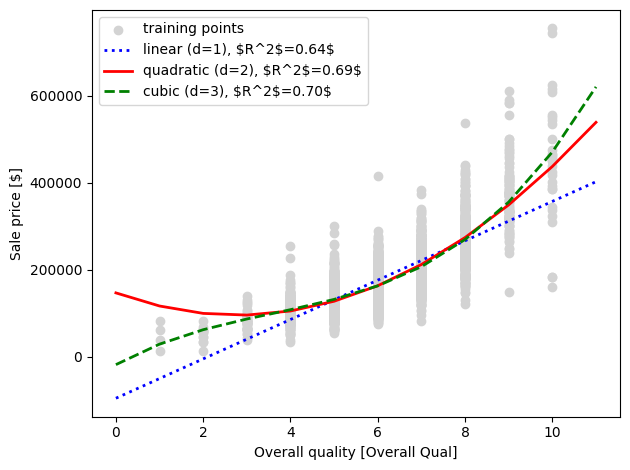

In [84]:
X=df[['Overall Qual']].values
y=df['SalePrice'].values
X=X[(df['Overall Qual']<4000)]
y=y[(df['Overall Qual']<4000)]

regr=LinearRegression()

quadratic=PolynomialFeatures(degree=2)
cubic=PolynomialFeatures(degree=3)
X_quad=quadratic.fit_transform(X)
X_cubic=cubic.fit_transform(X)

X_fit=np.arange(X.min()-1,X.max()+2,1)[:,np.newaxis]
regr.fit(X,y)
y_lin_fit=regr.predict(X_fit)
linear_r2=r2_score(y,regr.predict(X))
regr.fit(X_quad,y)
y_quad_fit=regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2=r2_score(y,regr.predict(X_quad))
regr.fit(X_cubic,y)
y_cubic_fit=regr.predict(cubic.fit_transform(X_fit))
cubic_r2=r2_score(y,regr.predict(X_cubic))

plt.scatter(X,y,label='training points',color='lightgray')
plt.plot(X_fit,y_lin_fit,label=f'linear (d=1), $R^2$={linear_r2:.2f}$',color='blue',lw=2,linestyle=':')
plt.plot(X_fit,y_quad_fit,label=f'quadratic (d=2), $R^2$={quadratic_r2:.2f}$',color='red',lw=2,linestyle='-')
plt.plot(X_fit,y_cubic_fit,label=f'cubic (d=3), $R^2$={cubic_r2:.2f}$',color='green',lw=2,linestyle='--')
plt.xlabel('Overall quality [Overall Qual]')
plt.ylabel('Sale price [$]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Random Forest Regression

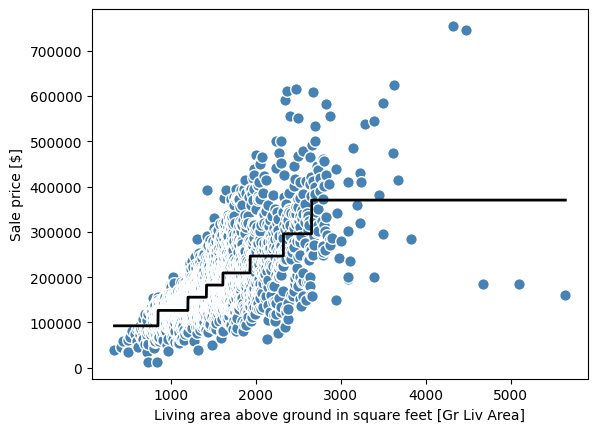

In [88]:
X=df[['Gr Liv Area']].values
y=df['SalePrice'].values
tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx=X.flatten().argsort()
lin_regplot(X[sort_idx],y[sort_idx],tree)
plt.xlabel('Living area above ground in square feet [Gr Liv Area]')
plt.ylabel('Sale price [$]')
plt.show()

In [91]:
target='SalePrice'
features=df.columns.drop(target)
X=df[features].values
y=df[target].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)

forest=RandomForestRegressor(n_estimators=1000,criterion='squared_error',random_state=1,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)
mae_train=mean_absolute_error(y_train,y_train_pred)
mae_test=mean_absolute_error(y_test,y_test_pred)
print(f'MAE train: {mae_train:.3f}, test: {mae_test:.3f}')
r2_train=r2_score(y_train,y_train_pred)
r2_test=r2_score(y_test,y_test_pred)
print(f'R^2 train: {r2_train:.3f}, test: {r2_test:.3f}')

MAE train: 8305.182, test: 20821.773
R^2 train: 0.976, test: 0.847


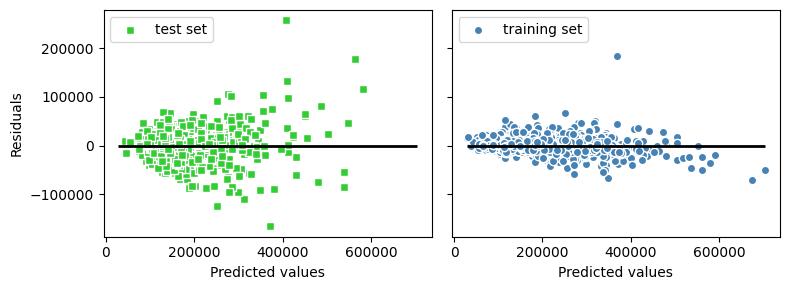

In [93]:
x_max=np.max([np.max(y_train_pred),np.max(y_test_pred)])
x_min=np.min([np.min(y_train_pred),np.min(y_test_pred)])

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,3),sharey=True)

ax1.scatter(y_test_pred,y_test_pred-y_test,c='limegreen',edgecolor='white',marker='s',label='test set')
ax2.scatter(y_train_pred,y_train_pred-y_train,c='steelblue',edgecolor='white',marker='o',label='training set')
ax1.set_ylabel('Residuals')

for ax in (ax1,ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0,xmin=x_min-100,xmax=x_max+100,color='black',lw=2)

plt.tight_layout()
plt.show()